In [52]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()  # for plot styling
import matplotlib.pyplot as plt
pd.options.mode.copy_on_write = True 
import datetime 

# Analisis Exploratorio de datos de Turismo en Argentina

##  Datos

### Fuente Datos Argentina datos.gob.ar

1) **pernoctes_por_localidad_segun_residencia.csv**: Pernoctaciones en hoteles y parahoteles por localidad de destino según tipo de residencia Cantidad de noches en hoteles y parahoteles por localidad de destino según tipo de residencia en formato de series de tiempo
https://datos.gob.ar/dataset/turismo_93db331e-6970-4d74-8589-c1223ac9c282/archivo/turismo_7b6ba47f-4aa9-4743-96be-d0e6157cfc5e


2) **coordenadas.csv**: valores de latitud y longitud de localidades Argentinas

3) **puna_base_agregada.csv**: Base agrupada del Padrón Único Nacional de Alojamiento (PUNA):
Base agrupada del Padrón Único Nacional de Alojamiento con datos de establecimientos, unidades, habitaciones y plazas de alojamientos turísticos.https://datos.gob.ar/dataset/turismo-padron-unico-nacional-alojamiento/archivo/turismo_01d23e57-ba58-48ed-a1c9-e1604ae78a1d


### 1. pernoctes_por_localidad_segun_residencia.csv
***

In [53]:
pernoctes=pd.read_csv('../Datos/pernoctes_por_localidad_segun_residencia.csv')

In [54]:
pernoctes.head(3)

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones
0,2018-01-01,Bahía Blanca,Total,16619.0,NaN
1,2018-01-01,Bahía Blanca,Residentes,15784.0,NaN
2,2018-01-01,Bahía Blanca,No residentes,835.0,NaN


### 2. coordenadas.csv
***

In [55]:
coord_loc=pd.read_csv('../Datos/coordenadas.csv', encoding='latin')

In [56]:
coord_loc.head(3)

,Localidad,Latitud,Longitud
0,Bahía Blanca,-38.7196,-62.2724
1,Bariloche,-41.1335,-71.3100
2,CABA,-34.6118,-58.4173


In [57]:
coord_loc.rename(columns={'Localidad':'localidad'}, inplace=True)

### 3. puna_base_agregada.csv
***

In [58]:
base_alojamientos=pd.read_csv('../Datos/puna_base_agregada.csv', encoding='latin')

In [59]:
base_alojamientos.head(1)

,indice_tiempo,region,ruta_natural,provincia_codigo,provincia_nombre,departamento_partido,localidad,clasificacion_minturdep,tipo,establecimientos,unidades,habitaciones,plazas
0,2020,Buenos Aires,Delta,6,Buenos Aires,Baradero,Baradero,Albergue municipal / complejo deportivo,Otros colectivos,1,0,6,30


In [60]:
base_alojamientos['tipo'].unique()

array(['Otros colectivos', 'Parahoteleros', 'Hoteleros'], dtype=object)

Creo una mascara para quedarme solo con los datos de tipo Parahoteleros y Hoteleros ya que el dataset de pernoctes_por_localidad_de_Residencia  solo cuenta con estas dos categorias. 

In [61]:
mascara_tipo=base_alojamientos['tipo'].isin(['Parahoteleros', 'Hoteleros'])

In [62]:
base_alojamientos=base_alojamientos[mascara_tipo]

Agrupo los plazas por localidad

In [63]:
base_alojamientos_agrupado=base_alojamientos.groupby(['indice_tiempo','localidad'])['plazas'].sum().reset_index()

Verifico los datos de palzas para la ciudad de Bariloche

In [64]:
base_alojamientos_agrupado[base_alojamientos_agrupado['localidad']=='San Carlos de Bariloche']

,indice_tiempo,localidad,plazas
878,2020,San Carlos de Bariloche,24207
2030,2021,San Carlos de Bariloche,24039
3181,2022,San Carlos de Bariloche,24653


Genero Diccionario de reemplazo de localidades para normalizarlas con el  dataset de pernoctes_por_localidad_de_Residencia. Comparé como estaban escritas las localidades en los dos datasets y cree este diccionario de sustiuciones para despues poder unirlos por localidad. 

In [65]:
reemplazo={'Bahía Blanca':'Bahia Blanca', 'Bariloche':'San Carlos de Bariloche', 'CABA':'Ciudad Autonoma de Buenos Aires', 'Calafate':'El Calafate', 'Carlos Paz':'Villa Carlos Paz',
       'Catamarca':'San Fernando del Valle de Catamarca', 'Córdoba':'Cordoba', 'Gualeguaychú':'Gualeguaychu', 'Jujuy':'San Salvador de Jujuy', 'La Angostura':'Villa La Angostura',
       'Malargue-Las Leñas':'Las Leñas', 'Neuquén':'Neuquen', 'Paraná':'Parana', 'Puerto Iguazú':'Puerto Iguazu',
       'Río Cuarto':'Rio Cuarto', 'San Martín de los Andes':'San Martin', 'Termas':'Termas de Rio Hondo', 'Tucumán':'San Miguel de Tucuman',
       'Valle de Uco':'Tunuyan'}

# Uniones de dataset

### Agregar coordenadas de localidad al dataset pernoctes

In [66]:
union_pernoctes=pd.merge(pernoctes, coord_loc, on='localidad')

Convierto columna indice_tiempo a datetime y agrego una columna que sea año

In [67]:
union_pernoctes['indice_tiempo']=pd.to_datetime(union_pernoctes['indice_tiempo'])
union_pernoctes['Año']=union_pernoctes['indice_tiempo'].dt.year

### Union con dataset de plazas

Utilizo el diccionario reemplazo para Normalizar las locaclidades entre los datasets de pernoctes y base_alojamiento.

In [68]:
union_pernoctes.localidad=union_pernoctes.localidad.replace(reemplazo)

In [69]:
base_alojamientos_agrupado.head(2)

,indice_tiempo,localidad,plazas
0,2020,25 de Mayo,419
1,2020,28 de Noviembre,81


In [70]:
base_alojamientos_agrupado.columns

Index(['indice_tiempo', 'localidad', 'plazas'], dtype='object')

In [71]:
base_alojamientos_agrupado.rename(columns={'indice_tiempo':'Año'}, inplace=True)

In [72]:
union_pernoctes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10584 entries, 0 to 10583
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   indice_tiempo     10584 non-null  datetime64[ns]
 1   localidad         10584 non-null  object        
 2   origen_pernoctes  10584 non-null  object        
 3   pernoctes         8825 non-null   float64       
 4   observaciones     3366 non-null   object        
 5   Latitud           10584 non-null  float64       
 6   Longitud          10584 non-null  float64       
 7   Año               10584 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), object(3)
memory usage: 620.3+ KB


Union del dataset con pernoctes y cantidad de plazas por localidad

In [73]:
pernoctes_con_plazas=pd.merge(union_pernoctes,base_alojamientos_agrupado, on=['localidad','Año'], how='left')

In [74]:
pernoctes_con_plazas[pernoctes_con_plazas['localidad']=='San Carlos de Bariloche']

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas
3,2018-01-01,San Carlos de Bariloche,Total,324603.0,NaN,-41.1335,-71.31,2018,NaN
4,2018-01-01,San Carlos de Bariloche,Residentes,254665.0,NaN,-41.1335,-71.31,2018,NaN
5,2018-01-01,San Carlos de Bariloche,No residentes,69938.0,NaN,-41.1335,-71.31,2018,NaN
150,2018-02-01,San Carlos de Bariloche,Total,271748.0,NaN,-41.1335,-71.31,2018,NaN
151,2018-02-01,San Carlos de Bariloche,Residentes,209620.0,NaN,-41.1335,-71.31,2018,NaN
...,...,...,...,...,...,...,...,...,...
10294,2023-11-01,San Carlos de Bariloche,Residentes,178831.0,Dato provisorio,-41.1335,-71.31,2023,NaN
10295,2023-11-01,San Carlos de Bariloche,No residentes,62489.0,Dato provisorio,-41.1335,-71.31,2023,NaN
10440,2023-12-01,San Carlos de Bariloche,Total,310615.0,Dato provisorio,-41.1335,-71.31,2023,NaN
10441,2023-12-01,San Carlos de Bariloche,Residentes,197496.0,Dato provisorio,-41.1335,-71.31,2023,NaN


In [75]:
nulos =pernoctes_con_plazas[pernoctes_con_plazas['plazas'].isna()]

In [76]:
nulos['localidad'].unique()

array(['Bahia Blanca', 'San Carlos de Bariloche',
       'Ciudad Autonoma de Buenos Aires', 'Cafayate', 'El Calafate',
       'Villa Carlos Paz', 'San Fernando del Valle de Catamarca',
       'Cordoba', 'Corrientes', 'Formosa', 'Gualeguaychu',
       'San Salvador de Jujuy', 'Villa La Angostura', 'La Falda',
       'La Rioja', 'Las Grutas', 'Las Leñas', 'Mar Chiquita',
       'Mar del Plata', 'Mendoza', 'Merlo', 'Mina Clavero', 'Neuquen',
       'Parana', 'Pinamar', 'Posadas', 'Puerto Iguazu', 'Puerto Madryn',
       'Rafaela', 'Resistencia', 'Rio Cuarto', 'Rio Gallegos', 'Rosario',
       'Salta', 'San Juan', 'San Luis', 'San Martin', 'San Rafael',
       'Santa Fe', 'Santa Rosa', 'Santiago del Estero', 'Tandil',
       'Termas de Rio Hondo', 'San Miguel de Tucuman', 'Ushuaia',
       'Tunuyan', 'Viedma', 'Villa General Belgrano', 'Villa Gesell'],
      dtype=object)

In [77]:
pernoctes_con_plazas[pernoctes_con_plazas['Año']==2022]

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas
7056,2022-01-01,Bahia Blanca,Total,15079.0,NaN,-38.7196,-62.2724,2022,1823.0
7057,2022-01-01,Bahia Blanca,Residentes,14690.0,NaN,-38.7196,-62.2724,2022,1823.0
7058,2022-01-01,Bahia Blanca,No residentes,389.0,NaN,-38.7196,-62.2724,2022,1823.0
7059,2022-01-01,San Carlos de Bariloche,Total,388088.0,NaN,-41.1335,-71.3100,2022,24653.0
7060,2022-01-01,San Carlos de Bariloche,Residentes,380605.0,NaN,-41.1335,-71.3100,2022,24653.0
...,...,...,...,...,...,...,...,...,...
8815,2022-12-01,Villa General Belgrano,Residentes,36984.0,NaN,-31.9795,-64.5293,2022,3204.0
8816,2022-12-01,Villa General Belgrano,No residentes,560.0,NaN,-31.9795,-64.5293,2022,3204.0
8817,2022-12-01,Villa Gesell,Total,140390.0,NaN,-37.2634,-56.9730,2022,17704.0
8818,2022-12-01,Villa Gesell,Residentes,140390.0,NaN,-37.2634,-56.9730,2022,17704.0


In [78]:
pernoctes_con_plazas.localidad.unique()

array(['Bahia Blanca', 'San Carlos de Bariloche',
       'Ciudad Autonoma de Buenos Aires', 'Cafayate', 'El Calafate',
       'Villa Carlos Paz', 'San Fernando del Valle de Catamarca',
       'Cordoba', 'Corrientes', 'Formosa', 'Gualeguaychu',
       'San Salvador de Jujuy', 'Villa La Angostura', 'La Falda',
       'La Rioja', 'Las Grutas', 'Las Leñas', 'Mar Chiquita',
       'Mar del Plata', 'Mendoza', 'Merlo', 'Mina Clavero', 'Neuquen',
       'Parana', 'Pinamar', 'Posadas', 'Puerto Iguazu', 'Puerto Madryn',
       'Rafaela', 'Resistencia', 'Rio Cuarto', 'Rio Gallegos', 'Rosario',
       'Salta', 'San Juan', 'San Luis', 'San Martin', 'San Rafael',
       'Santa Fe', 'Santa Rosa', 'Santiago del Estero', 'Tandil',
       'Termas de Rio Hondo', 'San Miguel de Tucuman', 'Ushuaia',
       'Tunuyan', 'Viedma', 'Villa General Belgrano', 'Villa Gesell'],
      dtype=object)

Guardo del dataset obtenido en un archivos CSV

In [79]:
union_pernoctes.to_csv('turismo_con_plazas')

### Datos de Google trends interest over time "Alojamiento Bariloche" en mundo
***

En esta seccion voy a agregar los datos de google trens al realizar la busqueda de las palabras alojamiento Bariloche en los ultimos 5 años.  El resultado es a nivel mundial. La bajada de datos la realice directamente desde la paginad e google trends aunque luego utilizare la API pytrends.

In [31]:
trends_Bariloche=pd.read_csv('../Datos/Tenrs_alojamiento_bariloche.csv', sep=',', skiprows=1 )

In [32]:
trends_Bariloche

,Semana,Alojamiento Bariloche: (Todo el mundo)
0,2019-03-03,30
1,2019-03-10,13
2,2019-03-17,25
3,2019-03-24,17
4,2019-03-31,24
...,...,...
256,2024-01-28,49
257,2024-02-04,36
258,2024-02-11,50
259,2024-02-18,31


Convierto la columna semana a formato datetime

In [33]:
trends_Bariloche['Semana'] = pd.to_datetime(trends_Bariloche['Semana'])


Agrego columna Mes y Año

In [34]:
trends_Bariloche['Mes']=trends_Bariloche['Semana'].dt.month

In [35]:
trends_Bariloche['Año']=trends_Bariloche['Semana'].dt.year

In [36]:
trends_Bariloche

,Semana,Alojamiento Bariloche: (Todo el mundo),Mes,Año
0,2019-03-03,30,3,2019
1,2019-03-10,13,3,2019
2,2019-03-17,25,3,2019
3,2019-03-24,17,3,2019
4,2019-03-31,24,3,2019
...,...,...,...,...
256,2024-01-28,49,1,2024
257,2024-02-04,36,2,2024
258,2024-02-11,50,2,2024
259,2024-02-18,31,2,2024


In [37]:
trends_Bariloche.columns

Index(['Semana', 'Alojamiento Bariloche: (Todo el mundo)', 'Mes', 'Año'], dtype='object')

Cambio nombre de columa Alojamiento Bariloche a valor (es el valor de interes de acuerdo a google)

In [38]:
trends_Bariloche.rename(columns={'Alojamiento Bariloche: (Todo el mundo)':'valor'}, inplace=True)

Realizo una agrupacion mensual para obtener un valor de interes por mes. 

In [39]:
bariloche_agrupado=trends_Bariloche.groupby(['Año','Mes'])['valor'].mean().reset_index()

In [40]:
bariloche_agrupado.head(3)

,Año,Mes,valor
0,2019,3,21.80
1,2019,4,23.00
2,2019,5,22.75


### Usando la API

In [154]:
import pytrends
from pytrends.request import TrendReq 
pytrends = TrendReq(hl='es-AR', tz=180)
kw_list = [ "Bariloche" ]
pytrends.build_payload(kw_list, cat= 0 , timeframe= 'today 5-y' )
data = pytrends.interest_over_time()
data = data.reset_index()

/Users/silvinademicco/anaconda3/envs/silvina2024/lib/python3.11/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


In [155]:
data 

,date,Bariloche,isPartial
0,2019-03-17,55,False
1,2019-03-24,52,False
2,2019-03-31,47,False
3,2019-04-07,51,False
4,2019-04-14,54,False
...,...,...,...
255,2024-02-04,71,False
256,2024-02-11,65,False
257,2024-02-18,65,False
258,2024-02-25,59,False


In [157]:
data['date'] = pd.to_datetime(data['date'])
data['Mes']=data['date'].dt.month
data['Año']=data['date'].dt.year
data_agrupado=data.groupby(['Año','Mes'])['Bariloche'].mean().reset_index()

In [159]:
data_agrupado

,Año,Mes,Bariloche
0,2019,3,51.333333
1,2019,4,51.500000
2,2019,5,54.750000
3,2019,6,65.800000
4,2019,7,81.750000
...,...,...,...
56,2023,11,59.250000
57,2023,12,63.200000
58,2024,1,79.500000
59,2024,2,65.000000


In [160]:
data_agrupado.rename(columns={'Bariloche':'valor'}, inplace=True)

### Union de trends con dataset de pernoctes y plazas

In [161]:
pernoctes_con_plazas['Mes']=pernoctes_con_plazas['indice_tiempo'].dt.month

In [162]:
pernoctes_con_plazas

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas,Mes
0,2018-01-01,Bahia Blanca,Total,16619.0,NaN,-38.7196,-62.2724,2018,NaN,1
1,2018-01-01,Bahia Blanca,Residentes,15784.0,NaN,-38.7196,-62.2724,2018,NaN,1
2,2018-01-01,Bahia Blanca,No residentes,835.0,NaN,-38.7196,-62.2724,2018,NaN,1
3,2018-01-01,San Carlos de Bariloche,Total,324603.0,NaN,-41.1335,-71.3100,2018,NaN,1
4,2018-01-01,San Carlos de Bariloche,Residentes,254665.0,NaN,-41.1335,-71.3100,2018,NaN,1
...,...,...,...,...,...,...,...,...,...,...
10579,2023-12-01,Villa General Belgrano,Residentes,37698.0,Dato provisorio,-31.9795,-64.5293,2023,NaN,12
10580,2023-12-01,Villa General Belgrano,No residentes,495.0,Dato provisorio,-31.9795,-64.5293,2023,NaN,12
10581,2023-12-01,Villa Gesell,Total,108886.0,Dato provisorio,-37.2634,-56.9730,2023,NaN,12
10582,2023-12-01,Villa Gesell,Residentes,108860.0,Dato provisorio,-37.2634,-56.9730,2023,NaN,12


Me quedo solo con los datos de pernoctes y plazas de Bariloche para unirlo con los trends de google, ademas me quedo solo con la categoria Todos de tipo de residente (que es la suma de los residentes mas los no residentes)

In [163]:
pernoctes_con_plazas_bari=pernoctes_con_plazas[(pernoctes_con_plazas['localidad']=='San Carlos de Bariloche')  & (pernoctes_con_plazas['origen_pernoctes']=='Total')]

In [164]:
pernoctes_con_plazas_bari

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas,Mes
3,2018-01-01,San Carlos de Bariloche,Total,324603.0,NaN,-41.1335,-71.31,2018,NaN,1
150,2018-02-01,San Carlos de Bariloche,Total,271748.0,NaN,-41.1335,-71.31,2018,NaN,2
297,2018-03-01,San Carlos de Bariloche,Total,168184.0,NaN,-41.1335,-71.31,2018,NaN,3
444,2018-04-01,San Carlos de Bariloche,Total,122681.0,NaN,-41.1335,-71.31,2018,NaN,4
591,2018-05-01,San Carlos de Bariloche,Total,84772.0,NaN,-41.1335,-71.31,2018,NaN,5
...,...,...,...,...,...,...,...,...,...,...
9852,2023-08-01,San Carlos de Bariloche,Total,388352.0,Dato provisorio,-41.1335,-71.31,2023,NaN,8
9999,2023-09-01,San Carlos de Bariloche,Total,371970.0,Dato provisorio,-41.1335,-71.31,2023,NaN,9
10146,2023-10-01,San Carlos de Bariloche,Total,314773.0,Dato provisorio,-41.1335,-71.31,2023,NaN,10
10293,2023-11-01,San Carlos de Bariloche,Total,241320.0,Dato provisorio,-41.1335,-71.31,2023,NaN,11


Unir datos de pernoctes con trends de google

In [165]:
pernoctes_con_plazas_bari.columns

Index(['indice_tiempo', 'localidad', 'origen_pernoctes', 'pernoctes',
       'observaciones', 'Latitud', 'Longitud', 'Año', 'plazas', 'Mes'],
      dtype='object')

In [166]:
data_agrupado.columns

Index(['Año', 'Mes', 'valor'], dtype='object')

In [167]:
union_con_trens=pd.merge(pernoctes_con_plazas_bari,data_agrupado, on=['Mes','Año'])

In [168]:
union_con_trens.head(3)

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas,Mes,valor
0,2019-03-01,San Carlos de Bariloche,Total,166884.0,NaN,-41.1335,-71.31,2019,NaN,3,51.333333
1,2019-04-01,San Carlos de Bariloche,Total,127177.0,NaN,-41.1335,-71.31,2019,NaN,4,51.500000
2,2019-05-01,San Carlos de Bariloche,Total,92354.0,NaN,-41.1335,-71.31,2019,NaN,5,54.750000


## Agrego una columna que tenga el valor de busquedas del mes anterior y otro que sea el promedio de los ultimos 4 valores

In [169]:
union_con_trens['valor_mes_anterior'] = union_con_trens['valor'].shift(1)

In [170]:
# Agregar la columna 'promedio_ultimos_4_valores'
union_con_trens['promedio_ultimos_4_valores'] = union_con_trens['valor'].rolling(window=3).mean()

In [171]:
union_con_trens['valor_mes_año_anterior'] = union_con_trens['valor'].shift(12)  # 12 meses en un año

In [172]:
union_con_trens.head(5)

,indice_tiempo,localidad,origen_pernoctes,pernoctes,observaciones,Latitud,Longitud,Año,plazas,Mes,valor,valor_mes_anterior,promedio_ultimos_4_valores,valor_mes_año_anterior
0,2019-03-01,San Carlos de Bariloche,Total,166884.0,NaN,-41.1335,-71.31,2019,NaN,3,51.333333,NaN,NaN,NaN
1,2019-04-01,San Carlos de Bariloche,Total,127177.0,NaN,-41.1335,-71.31,2019,NaN,4,51.500000,51.333333,NaN,NaN
2,2019-05-01,San Carlos de Bariloche,Total,92354.0,NaN,-41.1335,-71.31,2019,NaN,5,54.750000,51.500000,52.527778,NaN
3,2019-06-01,San Carlos de Bariloche,Total,143065.0,NaN,-41.1335,-71.31,2019,NaN,6,65.800000,54.750000,57.350000,NaN
4,2019-07-01,San Carlos de Bariloche,Total,372696.0,NaN,-41.1335,-71.31,2019,NaN,7,81.750000,65.800000,67.433333,NaN


## Analisis de Datos
### Grafico los valores de pernoctes en Bariloche y intereset over time de Alojamientos Bariloche

Valores de cantidad de pernoctes y valor de interes en google en el tiempo.

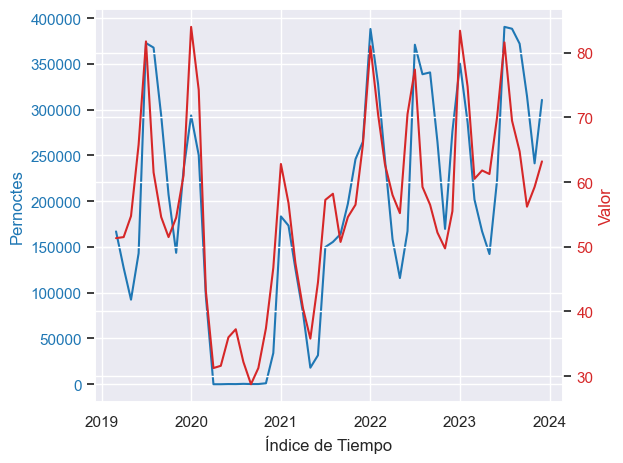

In [173]:

# Filtrar el DataFrame para obtener solo las columnas relevantes
df_filtrado = union_con_trens[['indice_tiempo', 'pernoctes', 'valor','valor_mes_anterior','promedio_ultimos_4_valores','Mes','Año','valor_mes_año_anterior']]

# Configurar el gráfico
fig, ax1 = plt.subplots()

# Graficar la primera variable en el eje y izquierdo
color = 'tab:blue'
ax1.set_xlabel('Índice de Tiempo')
ax1.set_ylabel('Pernoctes', color=color)
ax1.plot(df_filtrado['indice_tiempo'], df_filtrado['pernoctes'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Crear un segundo eje y para la segunda variable
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Valor', color=color)
ax2.plot(df_filtrado['indice_tiempo'], df_filtrado['valor'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Ajustar el diseño para evitar solapamiento
fig.tight_layout()

# Mostrar el gráfico
plt.show()


Pernoctes vs promedio de valores de trens de ultimos 4 meses.

<Axes: xlabel='promedio_ultimos_4_valores', ylabel='pernoctes'>

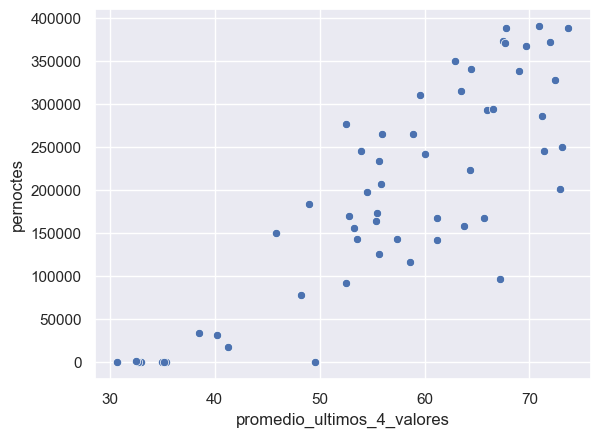

In [174]:
sns.scatterplot(data=union_con_trens, y='pernoctes', x='promedio_ultimos_4_valores')

Pernoctes vs valor interes

<Axes: xlabel='valor', ylabel='pernoctes'>

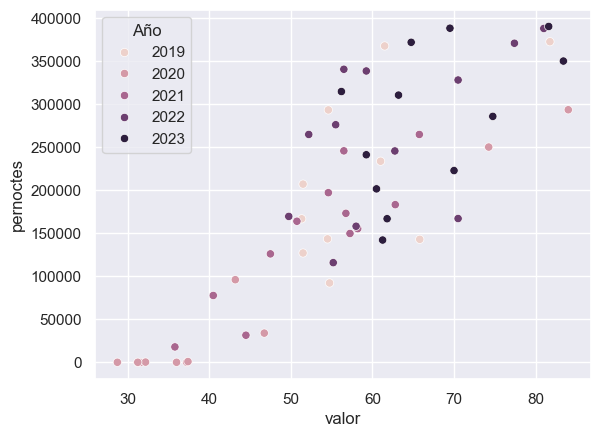

In [175]:
sns.scatterplot(data=union_con_trens, y='pernoctes', x='valor',hue='Año')

Pernoctes vs valor interes mes anterior

<Axes: xlabel='valor_mes_anterior', ylabel='pernoctes'>

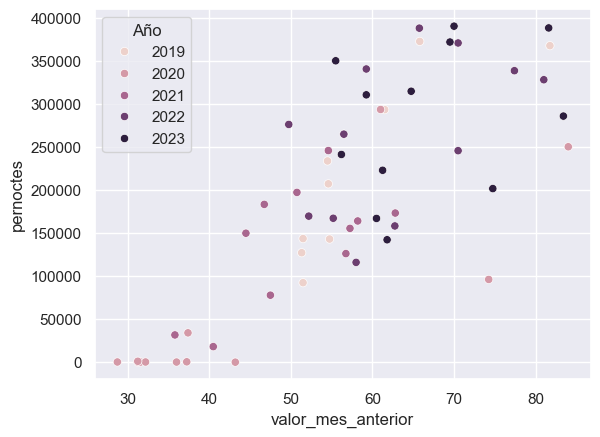

In [176]:
sns.scatterplot(data=union_con_trens, y='pernoctes', x='valor_mes_anterior',hue='Año')

### MODELO DE PREDICCION DE PERNOCTES MENSUAL EN BARILOCHE

Hago dos copias del dataframe creado para poder ver la performance del modelo convirtiendo mes y año a dummies y sin convertir. 

In [177]:
df=df_filtrado.copy()

In [178]:
df.head(3)

,indice_tiempo,pernoctes,valor,valor_mes_anterior,promedio_ultimos_4_valores,Mes,Año,valor_mes_año_anterior
0,2019-03-01,166884.0,51.333333,NaN,NaN,3,2019,NaN
1,2019-04-01,127177.0,51.500000,51.333333,NaN,4,2019,NaN
2,2019-05-01,92354.0,54.750000,51.500000,52.527778,5,2019,NaN


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   indice_tiempo               58 non-null     datetime64[ns]
 1   pernoctes                   58 non-null     float64       
 2   valor                       58 non-null     float64       
 3   valor_mes_anterior          57 non-null     float64       
 4   promedio_ultimos_4_valores  56 non-null     float64       
 5   Mes                         58 non-null     int32         
 6   Año                         58 non-null     int32         
 7   valor_mes_año_anterior      46 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int32(2)
memory usage: 3.3 KB


In [180]:
df['Mes'] = df['Mes'].astype(str)
df['Año'] = df['Año'].astype(str)

In [181]:
df = pd.get_dummies(df, columns=['Mes', 'Año'], prefix=['Mes', 'Año'], drop_first=True, dtype=int )

In [182]:
df.head()

,indice_tiempo,pernoctes,valor,valor_mes_anterior,promedio_ultimos_4_valores,valor_mes_año_anterior,Mes_10,Mes_11,Mes_12,Mes_2,...,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9,Año_2020,Año_2021,Año_2022,Año_2023
0,2019-03-01,166884.0,51.333333,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-04-01,127177.0,51.500000,51.333333,NaN,NaN,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2019-05-01,92354.0,54.750000,51.500000,52.527778,NaN,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2019-06-01,143065.0,65.800000,54.750000,57.350000,NaN,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2019-07-01,372696.0,81.750000,65.800000,67.433333,NaN,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [183]:
df.columns

Index(['indice_tiempo', 'pernoctes', 'valor', 'valor_mes_anterior',
       'promedio_ultimos_4_valores', 'valor_mes_año_anterior', 'Mes_10',
       'Mes_11', 'Mes_12', 'Mes_2', 'Mes_3', 'Mes_4', 'Mes_5', 'Mes_6',
       'Mes_7', 'Mes_8', 'Mes_9', 'Año_2020', 'Año_2021', 'Año_2022',
       'Año_2023'],
      dtype='object')

In [184]:
df = pd.concat([df, df_filtrado[['Año', 'Mes']]], axis=1)

In [185]:
df.head(3)

,indice_tiempo,pernoctes,valor,valor_mes_anterior,promedio_ultimos_4_valores,valor_mes_año_anterior,Mes_10,Mes_11,Mes_12,Mes_2,...,Mes_6,Mes_7,Mes_8,Mes_9,Año_2020,Año_2021,Año_2022,Año_2023,Año,Mes
0,2019-03-01,166884.0,51.333333,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,2019,3
1,2019-04-01,127177.0,51.500000,51.333333,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,2019,4
2,2019-05-01,92354.0,54.750000,51.500000,52.527778,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,2019,5


In [186]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import optuna

### 1. Regresion Lineal

In [187]:

# Ordenar por 'indice_tiempo'
df = df.sort_values(by='indice_tiempo')

# Imputar valores nulos
# df = df.fillna(0)  # Puedes usar diferentes estrategias para imputar valores nulos según tus necesidades

# Definir las features (X) y la target (y)
features = ['valor']
target = ['pernoctes']

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# Inicializar el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')
# Imprimir los coeficientes del modelo
print('Coeficientes del modelo:')
for feature, coef in zip(features, model.coef_):
    print(f'{feature}: {coef}')

# Imprimir el intercepto del modelo
print(f'Intercepto del modelo: {model.intercept_}')


Mean Squared Error: 5579823051.366801
r2: 0.1840780555568552
Coeficientes del modelo:
valor: [7228.52829044]
Intercepto del modelo: [-220912.28978437]


### 2. Arbol de Decisión 

        Real  Predicción
46  350187.0    126153.0
47  285907.0    328164.0
48  201686.0    245715.0
49  167006.0    158266.0
50  142228.0    158266.0
51  222950.0    340647.0
52  390398.0    370874.0
53  388352.0    367734.0
54  371970.0    370874.0
55  314773.0    372696.0
56  241320.0    245854.0
57  310615.0    340647.0


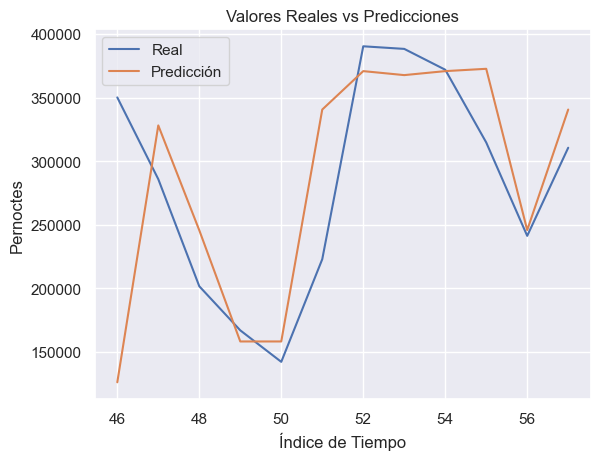

Mean Squared Error: 6098889227.0
r2: 0.1081764580655934


In [188]:


# Ordenar por 'indice_tiempo'
df = df.sort_values(by='indice_tiempo')

# Imputar valores nulos
df = df.fillna(0)  # Puedes usar diferentes estrategias para imputar valores nulos según tus necesidades

# Definir las features (X) y la target (y)
features = ['valor_mes_anterior','Mes','Año']
target = 'pernoctes'

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Inicializar el modelo de árbol de decisión
model = DecisionTreeRegressor()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Mostrar los valores reales y las predicciones
results_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
print(results_df)

# Graficar los resultados
plt.plot(results_df.index, results_df['Real'], label='Real')
plt.plot(results_df.index, results_df['Predicción'], label='Predicción')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Pernoctes')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')



### 3. Arbol de Decisión con Dummies

In [189]:
df2 = df2.fillna(0)
features = ['valor_mes_anterior',
        'Mes_10', 'Mes_11', 'Mes_12', 'Mes_2', 'Mes_3', 'Mes_4',
       'Mes_5', 'Mes_6', 'Mes_7', 'Mes_8', 'Mes_9', 'Año_2020',
       'Año_2021', 'Año_2022', 'Año_2023']
target = 'pernoctes'

X = df2[features]
y = df2[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Inicializar el modelo de árbol de decisión
model = DecisionTreeRegressor()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')

NameError: name 'df2' is not defined

### 4. Modelos de Ensamble XGBoostRegressor

#### XGBoostRegressor con dummies

[I 2024-03-12 17:14:37,978] A new study created in memory with name: no-name-d8496282-5c73-45d4-8897-4d8c7921de6e
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_2215/3864557736.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_2215/3864557736.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
[I 2024-03-12 17:14:38,010] Trial 0 finished with value: -0.20309958137149864 and parameters: {'booster': 'gbtree', 'lambda': 0.024736483536231996, 'alpha': 3.104053327976468e-05, 'colsample_bytre

Mejores hiperparámetros: {'booster': 'gblinear', 'lambda': 2.400473610836636e-08, 'alpha': 2.9829879262582746e-07, 'colsample_bytree': 0.5635162030672404, 'subsample': 0.18563091880911467, 'learning_rate': 0.2997163133089979, 'n_estimators': 286, 'max_depth': 6, 'min_child_weight': 2}
Mejor valor de r2: 0.6561251594674384
        Real    Predicción
46  350187.0  355888.56250
47  285907.0  345455.25000
48  201686.0  283861.00000
49  167006.0  172617.59375
50  142228.0  159045.28125
51  222950.0  189206.75000
52  390398.0  323872.65625
53  388352.0  322929.84375
54  371970.0  302690.03125
55  314773.0  271609.90625
56  241320.0  220422.43750
57  310615.0  285220.62500


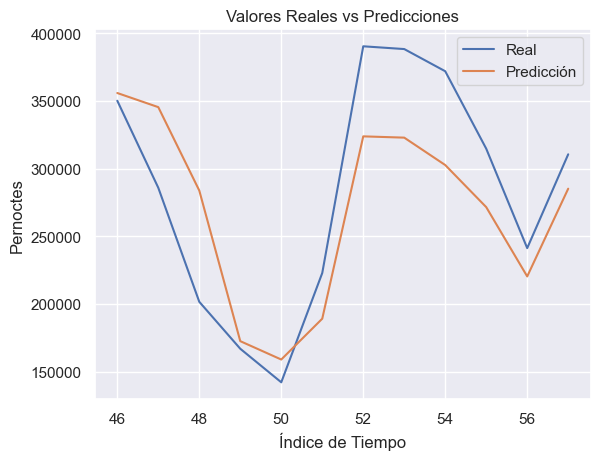

Mean Squared Error: 2352848282.7693686
r2: 0.6559495653922844


In [190]:



# Definir las features (X) y la target (y)
features = ['valor_mes_anterior', 'Mes_10', 'Mes_11', 'Mes_12', 'Mes_2', 'Mes_3', 'Mes_4',
       'Mes_5', 'Mes_6', 'Mes_7', 'Mes_8', 'Mes_9', 'Año_2020',
       'Año_2021', 'Año_2022', 'Año_2023']
target = 'pernoctes'

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    return r2

# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los resultados de la optimización
print('Mejores hiperparámetros:', study.best_params)
print('Mejor valor de r2:', study.best_value)

# Obtener el modelo con los mejores hiperparámetros
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)

# Entrenar el modelo con todos los datos de entrenamiento
best_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Mostrar los valores reales y las predicciones
results_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
print(results_df)

# Graficar los resultados
plt.plot(results_df.index, results_df['Real'], label='Real')
plt.plot(results_df.index, results_df['Predicción'], label='Predicción')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Pernoctes')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')


#### XGBoostRegressor sin dummies

[I 2024-03-12 17:34:43,850] A new study created in memory with name: no-name-e8386044-6105-42a1-ab11-0f479d7f8c3a
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_2215/2521324240.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
/var/folders/n9/fw43flpn4k74bk1f25xmgj340000gn/T/ipykernel_2215/2521324240.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
[I 2024-03-12 17:34:43,971] Trial 0 finished with value: -1.7362710001238812 and parameters: {'booster': 'dart', 'lambda': 6.590510491579279e-07, 'alpha': 3.1573159282186774e-07, 'colsample_bytree

Mejores hiperparámetros: {'booster': 'dart', 'lambda': 7.004156122087702e-08, 'alpha': 0.010063869362136315, 'colsample_bytree': 0.9786304964819076, 'subsample': 0.9428520792326829, 'learning_rate': 0.27775058602184016, 'n_estimators': 68, 'max_depth': 4, 'min_child_weight': 3}
Mejor valor de r2: 0.9310044211339815
        Real     Predicción
46  350187.0  297983.687500
47  285907.0  325494.375000
48  201686.0  217332.156250
49  167006.0  167745.187500
50  142228.0  207638.593750
51  222950.0  244424.937500
52  390398.0  386326.250000
53  388352.0  373548.500000
54  371970.0  390709.375000
55  314773.0  303149.250000
56  241320.0  245974.421875
57  310615.0  335002.875000


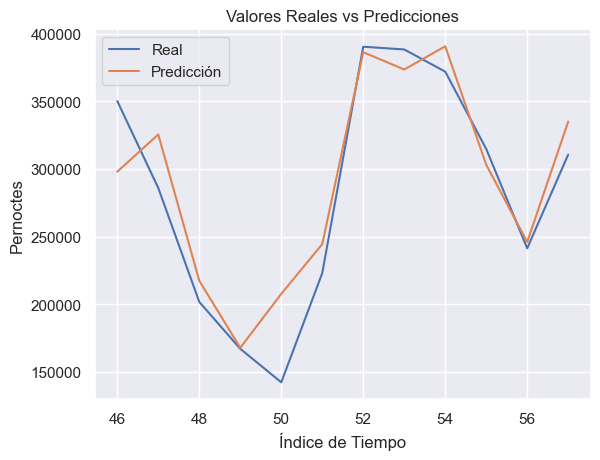

Mean Squared Error: 884653667.0042521
r2: 0.8706395644635975


In [196]:


# Definir las features (X) y la target (y)
features = ['valor_mes_anterior','Mes','Año']
target = 'pernoctes'

X = df[features]
y = df[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    return r2

# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los resultados de la optimización
print('Mejores hiperparámetros:', study.best_params)
print('Mejor valor de r2:', study.best_value)

# Obtener el modelo con los mejores hiperparámetros
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)

# Entrenar el modelo con todos los datos de entrenamiento
best_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Mostrar los valores reales y las predicciones
results_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
print(results_df)

# Graficar los resultados
plt.plot(results_df.index, results_df['Real'], label='Real')
plt.plot(results_df.index, results_df['Predicción'], label='Predicción')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Pernoctes')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'r2: {r2}')

### Elijo el ultimo modelos de XGBoost sin dummies (como son pocos datos al aplicar dummies se pierde informacion)
Obtengo los valores de residuos para determinar el intervalo de confianza de la prediccion del modelo con un nivel de significancia de 0.05.

In [197]:

# Obtener predicciones y residuos en el conjunto de prueba
predicciones = best_model.predict(X_test)
residuos = y_test - predicciones

# Calcular desviación estándar de los residuos en el conjunto de prueba
desviacion_estandar_test = np.std(residuos)

# Construir intervalo de confianza del 95%
intervalo_confianza_test = 1.96 * desviacion_estandar_test
limite_superior_test = predicciones + intervalo_confianza_test
limite_inferior_test = predicciones - intervalo_confianza_test




In [198]:
print(intervalo_confianza_test)

55566.85471623692


Para estar segura que esta ok aplicar el criterio anterior de intervalo de confianza verifico que los residuos sigan una distribucion normal aplicando la prueba de normalidad de Shapiro-Wilk

Predicción: 306100.0625, Intervalo de confianza (Test): (258060.71875, 354139.40625)
Predicción: 327334.625, Intervalo de confianza (Test): (279295.28125, 375373.96875)
Predicción: 234226.359375, Intervalo de confianza (Test): (186187.015625, 282265.71875)
Predicción: 175131.953125, Intervalo de confianza (Test): (127092.609375, 223171.296875)
Predicción: 185296.359375, Intervalo de confianza (Test): (137257.015625, 233335.703125)
Predicción: 211961.3125, Intervalo de confianza (Test): (163921.96875, 260000.65625)
Predicción: 382049.0625, Intervalo de confianza (Test): (334009.71875, 430088.40625)
Predicción: 366707.1875, Intervalo de confianza (Test): (318667.84375, 414746.53125)
Predicción: 375320.6875, Intervalo de confianza (Test): (327281.34375, 423360.03125)
Predicción: 309235.78125, Intervalo de confianza (Test): (261196.4375, 357275.125)
Predicción: 246775.609375, Intervalo de confianza (Test): (198736.265625, 294814.96875)
Predicción: 317765.6875, Intervalo de confianza (Test)

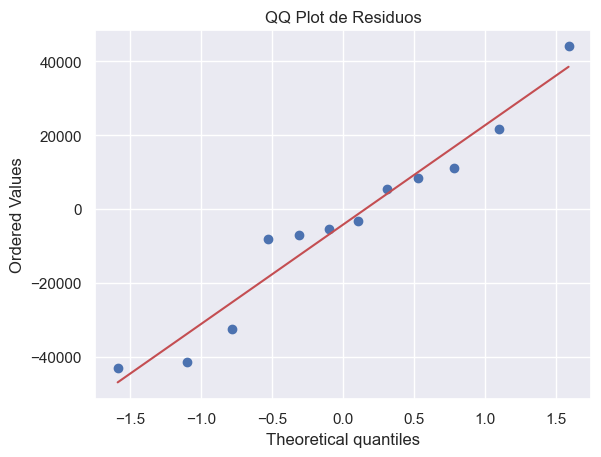

Prueba de Shapiro-Wilk - Estadístico: 0.9499182281812669, Valor p: 0.6357894761711035
Los residuos parecen seguir una distribución normal (p > 0.05)


In [194]:
from scipy.stats import shapiro, probplot
for i in range(len(X_test)):
    print(f"Predicción: {predicciones[i]}, Intervalo de confianza (Test): ({limite_inferior_test[i]}, {limite_superior_test[i]})")

# Graficar el QQ plot
probplot(residuos, dist="norm", plot=plt)
plt.title('QQ Plot de Residuos')
plt.show()

# Prueba de normalidad de Shapiro-Wilk
shapiro_test_statistic, shapiro_p_value = shapiro(residuos)
print(f"Prueba de Shapiro-Wilk - Estadístico: {shapiro_test_statistic}, Valor p: {shapiro_p_value}")

# Interpretar los resultados
alpha = 0.05
if shapiro_p_value > alpha:
    print("Los residuos parecen seguir una distribución normal (p > 0.05)")
else:
    print("Los residuos no parecen seguir una distribución normal (p <= 0.05)")

Creo un grafico con los valores reales, las predicciones y los intervalos de confiaza. 

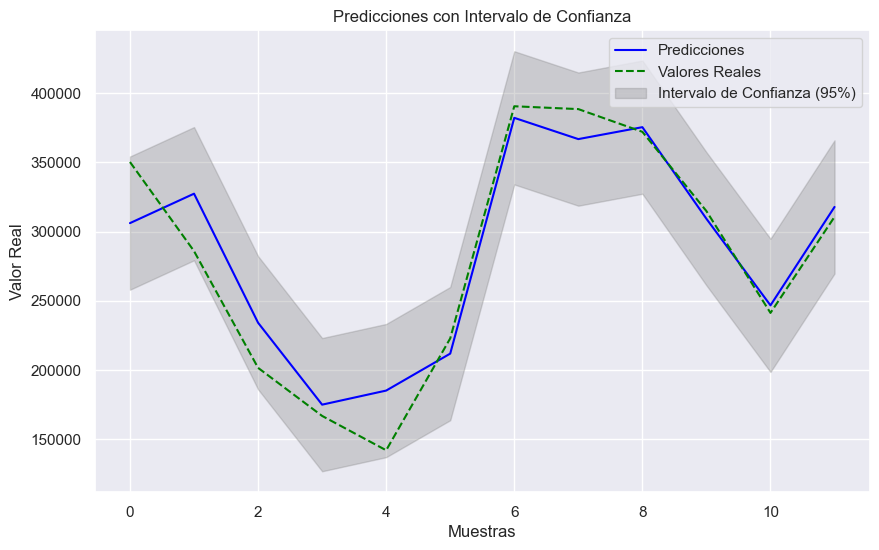

In [195]:
# Crear un gráfico
plt.figure(figsize=(10, 6))

# Graficar las predicciones
plt.plot(predicciones, label='Predicciones', color='blue')
# Graficar los valores reales
plt.plot(y_test.values, label='Valores Reales', color='green', linestyle='--')

# Graficar el intervalo de confianza en gris
plt.fill_between(range(len(y_test)), limite_inferior_test, limite_superior_test, color='gray', alpha=0.3, label='Intervalo de Confianza (95%)')

# Añadir etiquetas y leyenda
plt.xlabel('Muestras')
plt.ylabel('Valor Real')
plt.title('Predicciones con Intervalo de Confianza')
plt.legend()

# Mostrar el gráfico
plt.show()


Guardo el modelo para luego tomarlo en la app streamlit

In [199]:
best_model.save_model('xgb_model_turismo_5.json')

In [150]:
X_test_final = pd.concat([X_test, results_df['Predicción']], axis=1)

In [151]:
X_test_final = pd.concat([X_test_final, results_df['Real']], axis=1)

In [152]:
X_test_final 

,valor_mes_anterior,Mes,Año,Predicción,Real
46,36.00,1,2023,388576.125000,350187.0
47,77.00,2,2023,342468.218750,285907.0
48,63.25,3,2023,228049.203125,201686.0
49,35.00,4,2023,132032.156250,167006.0
50,46.00,5,2023,170323.000000,142228.0
51,34.75,6,2023,180650.937500,222950.0
52,41.75,7,2023,340337.906250,390398.0
53,42.20,8,2023,336490.406250,388352.0
54,25.25,9,2023,298277.281250,371970.0
55,37.75,10,2023,272362.031250,314773.0


In [202]:
X_test_final['Fecha'] = X_test_final['Mes'].astype(str) + '/' + X_test_final['Año'].astype(str)
X_test_final['Fecha'] = pd.to_datetime(X_test_final['Fecha'], format='%m/%Y')

In [203]:
valores_reales=X_test_final[['Fecha','Mes','Año','Real','valor_mes_anterior']]

In [ ]:
dic_mes ={
    1: 31,
    2: 28,
    3: 31,
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 31,
    9: 30,
    10: 31,
    11: 30,
    12: 31
}

In [ ]:
valores_reales['cantidad_dias']=valores_reales['Mes'].replace(dic_mes)

In [ ]:
valores_reales['total_plazas_mes']=valores_reales['cantidad_dias']*24653


In [ ]:
valores_reales['ocupacion_real']=(valores_reales['Real']/valores_reales['total_plazas_mes'])*100


In [ ]:
valores_reales

,Fecha,Mes,Año,Real,valor_mes_anterior,cantidad_dias,total_plazas_mes,ocupacion_real
138,2023-01-01,1,2023,350187.0,43.50,31,764243,45.821421
141,2023-02-01,2,2023,285907.0,84.20,28,690284,41.418749
144,2023-03-01,3,2023,201686.0,56.25,31,764243,26.390297
147,2023-04-01,4,2023,167006.0,35.75,30,739590,22.580889
150,2023-05-01,5,2023,142228.0,39.40,31,764243,18.610311
153,2023-06-01,6,2023,222950.0,35.00,30,739590,30.145080
156,2023-07-01,7,2023,390398.0,46.00,31,764243,51.082967
159,2023-08-01,8,2023,388352.0,47.40,31,764243,50.815251
162,2023-09-01,9,2023,371970.0,26.50,30,739590,50.294082
165,2023-10-01,10,2023,314773.0,29.25,31,764243,41.187554


In [ ]:
valores_reales.to_csv('valores_reales')

In [ ]:
X_test_final['Fecha'] = X_test_final['Mes'].astype(str) + '/' + X_test_final['Año'].astype(str)


In [ ]:
X_test_final['Fecha'] = pd.to_datetime(X_test_final['Fecha'], format='%m/%Y')

In [ ]:
X_test_final

,valor_mes_anterior,Mes,Año,Predicción,Real,Fecha
138,43.50,1,2023,411444.468750,350187.0,2023-01-01
141,84.20,2,2023,329272.218750,285907.0,2023-02-01
144,56.25,3,2023,205866.328125,201686.0,2023-03-01
147,35.75,4,2023,175405.765625,167006.0,2023-04-01
150,39.40,5,2023,193683.703125,142228.0,2023-05-01
153,35.00,6,2023,218857.109375,222950.0,2023-06-01
156,46.00,7,2023,397666.375000,390398.0,2023-07-01
159,47.40,8,2023,344723.406250,388352.0,2023-08-01
162,26.50,9,2023,329889.812500,371970.0,2023-09-01
165,29.25,10,2023,300315.812500,314773.0,2023-10-01
